[*********************100%***********************]  1 of 1 completed


Columns in the data: MultiIndex([('Adj Close', 'RELIANCE.BO'),
            (    'Close', 'RELIANCE.BO'),
            (     'High', 'RELIANCE.BO'),
            (      'Low', 'RELIANCE.BO'),
            (     'Open', 'RELIANCE.BO'),
            (   'Volume', 'RELIANCE.BO')],
           names=['Price', 'Ticker'])
Columns after flattening: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


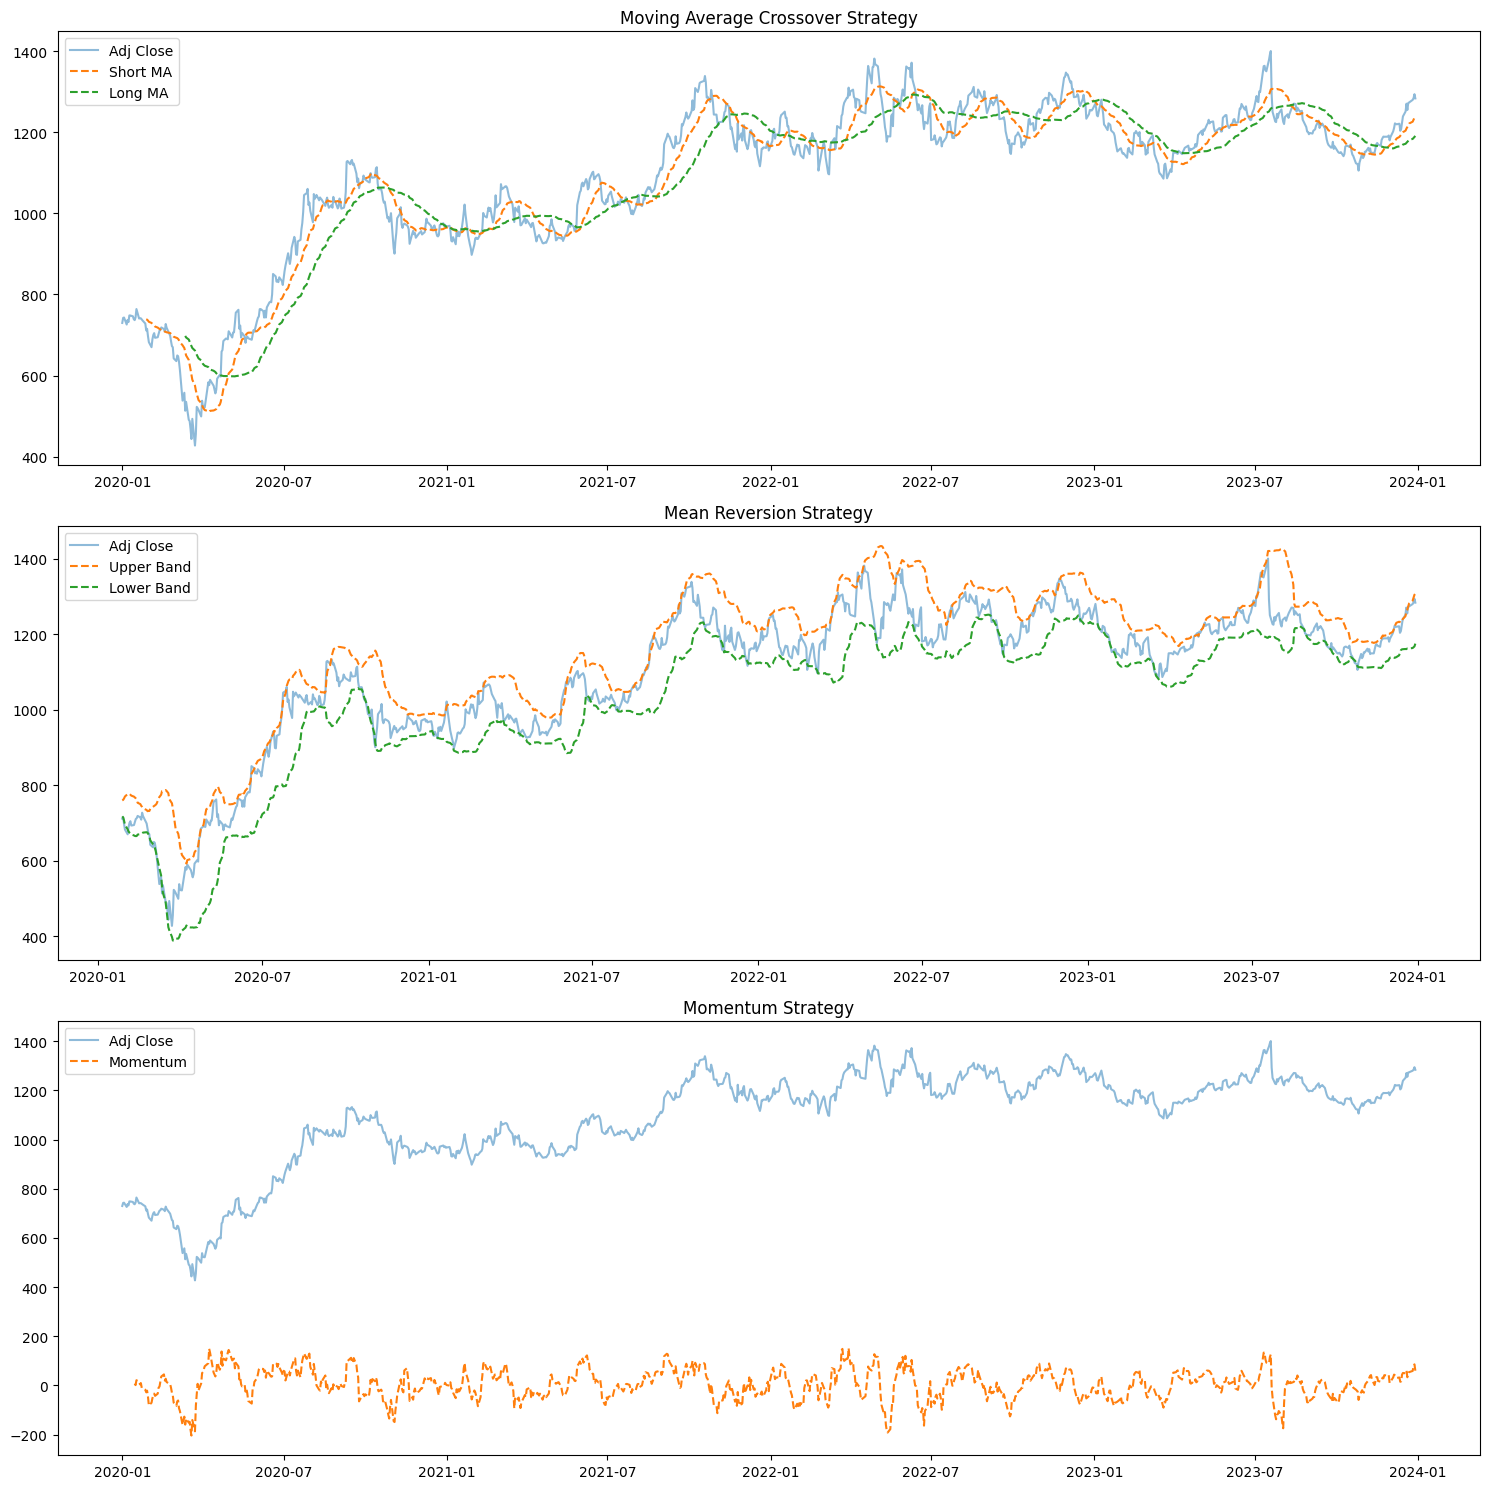

In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download Historical Stock Data
symbol = 'RELIANCE.BO'  # Replace with any Sensex company symbol (e.g., 'TCS.BO', 'INFY.BO')
data = yf.download(symbol, start='2020-01-01', end='2023-12-31')

# Debug: Print columns in the dataset
print("Columns in the data:", data.columns)

# Step 2: Flatten MultiIndex Columns if Present
if isinstance(data.columns, pd.MultiIndex):
    # Since we have only one ticker, we can drop the second level
    data.columns = data.columns.get_level_values(0)
    print("Columns after flattening:", data.columns)
else:
    print("No MultiIndex columns detected.")

# Proceed only if 'Adj Close' is present
if 'Adj Close' not in data.columns:
    raise KeyError("Column 'Adj Close' is missing from the data.")

# Calculate Return
data['Return'] = data['Adj Close'].pct_change()

# Step 3: Moving Average Crossover Strategy
def moving_average_crossover(data, short_window=20, long_window=50):
    data = data.copy()
    data['Short_MA'] = data['Adj Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window).mean()
    data['Signal'] = 0
    data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1
    data.loc[data['Short_MA'] <= data['Long_MA'], 'Signal'] = -1
    return data

# Step 4: Mean Reversion Strategy
def mean_reversion_strategy(data, window=20, threshold=2):
    data = data.copy()  # Create a copy to avoid modifying the original DataFrame

    # Check if 'Adj Close' exists
    if 'Adj Close' not in data.columns:
        raise KeyError("Column 'Adj Close' is missing from the data.")

    # Calculate rolling mean and standard deviation
    data['Rolling_Mean'] = data['Adj Close'].rolling(window=window).mean()
    data['Rolling_Std'] = data['Adj Close'].rolling(window=window).std()

    # Calculate upper and lower bands
    data['Upper_Band'] = data['Rolling_Mean'] + threshold * data['Rolling_Std']
    data['Lower_Band'] = data['Rolling_Mean'] - threshold * data['Rolling_Std']

    # Debug: Check if columns are created
    required_columns = ['Rolling_Mean', 'Rolling_Std', 'Upper_Band', 'Lower_Band']
    for col in required_columns:
        if col not in data.columns:
            raise KeyError(f"Column '{col}' was not created successfully.")

    # Drop rows with NaN values (these occur at the start due to rolling calculations)
    data.dropna(subset=required_columns, inplace=True)

    # Generate signals with proper alignment
    data['Signal'] = 0
    data.loc[data['Adj Close'] < data['Lower_Band'], 'Signal'] = 1  # Buy
    data.loc[data['Adj Close'] > data['Upper_Band'], 'Signal'] = -1  # Sell

    return data

# Step 5: Momentum Strategy
def momentum_strategy(data, momentum_window=10):
    data = data.copy()
    data['Momentum'] = data['Adj Close'].diff(momentum_window)
    data['Signal'] = 0
    data.loc[data['Momentum'] > 0, 'Signal'] = 1  # Buy
    data.loc[data['Momentum'] <= 0, 'Signal'] = -1  # Sell
    return data

# Step 6: Apply Strategies
ma_crossover_data = moving_average_crossover(data.copy())
mean_reversion_data = mean_reversion_strategy(data.copy())
momentum_data = momentum_strategy(data.copy())

# Step 7: Plot the Results
plt.figure(figsize=(15, 15))

# Moving Average Crossover Plot
plt.subplot(3, 1, 1)
plt.plot(ma_crossover_data['Adj Close'], label='Adj Close', alpha=0.5)
plt.plot(ma_crossover_data['Short_MA'], label='Short MA', linestyle='--')
plt.plot(ma_crossover_data['Long_MA'], label='Long MA', linestyle='--')
plt.title('Moving Average Crossover Strategy')
plt.legend()

# Mean Reversion Plot
plt.subplot(3, 1, 2)
plt.plot(mean_reversion_data['Adj Close'], label='Adj Close', alpha=0.5)
plt.plot(mean_reversion_data['Upper_Band'], label='Upper Band', linestyle='--')
plt.plot(mean_reversion_data['Lower_Band'], label='Lower Band', linestyle='--')
plt.title('Mean Reversion Strategy')
plt.legend()

# Momentum Plot
plt.subplot(3, 1, 3)
plt.plot(momentum_data['Adj Close'], label='Adj Close', alpha=0.5)
plt.plot(momentum_data['Momentum'], label='Momentum', linestyle='--')
plt.title('Momentum Strategy')
plt.legend()

plt.tight_layout()
plt.show()
